In [1]:
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# int mappings 
chrs = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chrs, 1)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# ----------- Attempting my own from the paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [5]:
# Generate input / output pairs
block_size = 3

X, Y = [], []

for w in words[:]:
    # print(w)

    context = [0] * block_size 
    for ch in (w + '.'):
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

# for x, y in zip(X,Y):
#     print(f'{x} -----> {y}')

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f'Num of training samples: {X.shape[0]}')

Num of training samples: 228146


In [6]:
# Build the network: y = b + U*tanh(d+Hx)
feature_dimensions=10 
hidden_units=200

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((len(stoi),feature_dimensions), requires_grad=True, generator=g) # e.g., C is (27,2); if X is (5,3) then C[X] is (5,3,2)
H = torch.randn((block_size*feature_dimensions,hidden_units), requires_grad=True, generator=g) # e.g., (3*2,20)
d = torch.randn(hidden_units, requires_grad=True, generator=g) # e.g., (20,)
U = torch.randn((hidden_units,len(stoi)), requires_grad=True, generator=g) # e.g., (20, 27)
b = torch.randn(len(stoi), requires_grad=True, generator=g) # e.g., (27,)

parameters = [C, H, d, U, b]
print(f'Total params: {sum(p.nelement() for p in parameters)}')

Total params: 11897


In [7]:
# fwd pass 
h = (C[X].view(X.shape[0],-1) @ H) + d
logits = (h.tanh() @ U) + b
counts = logits.exp()
probs = counts/counts.sum(axis=1, keepdims=True)

In [8]:
# loss function 
prob = probs[torch.arange(X.shape[0]),Y]
loss = -prob.log().mean()
print (f'loss: {loss.item():.4f}')

loss: 26.0063


In [9]:
# reset grad
for p in parameters:
    p.grad = None

In [10]:
# backward
loss.backward()

In [11]:
# parameter adjust 
for p in parameters:
    p.data += -0.1*p.grad

In [12]:
for step in range(20000):
    # fwd pass 
    h = (C[X].view(X.shape[0],-1) @ H) + d
    logits = (h.tanh() @ U) + b
    counts = logits.exp()
    probs = counts/counts.sum(axis=1, keepdims=True)
    
    # loss function 
    prob = probs[torch.arange(X.shape[0]),Y]
    loss = -prob.log().mean()
    if step % 100 == 0: 
        print (f'Step: {step}, loss: {loss.item():.4f}')
        
    # reset grad
    for p in parameters:
        p.grad = None
        
    # backward
    loss.backward()
    
    # parameter adjust 
    for p in parameters:
        p.data += -0.1*p.grad

Step: 0, loss: 24.3454
Step: 100, loss: 7.8302
Step: 200, loss: 6.1041
Step: 300, loss: 5.2354
Step: 400, loss: 4.6519
Step: 500, loss: 4.2553
Step: 600, loss: 3.9732
Step: 700, loss: 3.7591
Step: 800, loss: 3.5821
Step: 900, loss: 3.4183
Step: 1000, loss: 3.2803
Step: 1100, loss: 3.1760
Step: 1200, loss: 3.0869
Step: 1300, loss: 3.0117
Step: 1400, loss: 2.9462
Step: 1500, loss: 2.8867
Step: 1600, loss: 2.8339
Step: 1700, loss: 2.7835
Step: 1800, loss: 2.7407
Step: 1900, loss: 2.7052
Step: 2000, loss: 2.6702
Step: 2100, loss: 2.6451
Step: 2200, loss: 2.6161
Step: 2300, loss: 2.5925


KeyboardInterrupt: 

In [13]:
import torch.nn.functional as F
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = (emb.view(1,-1) @ H) + d
        logits = (h.tanh() @ U) + b
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amoril.
khkimylirtety.
salassa.
jazhnen.
amerahti.
aeai.
nertara.
chaiir.
kanhin.
dham.
joce.
quint.
salin.
alianbi.
waver.
giearyxi.
jaxduni.
saylen.
eao.


In [14]:
# -------------- Decent result, loss @ 2.6 after ~2100 iterations across entire training set but missed a few things:
#     * Creating training, validation and test sets 
#     * Creating minibatches from the training set 
#     * Adapting the learning rate over steps 

# --------------- Retrying again with those adjustments 

In [15]:
import torch, torch.nn.functional as F
import numpy 
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Create the vocabulary 

words = open('names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chrs,1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

stoi, itos

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'})

In [39]:
# Generate the samples 

block_size = 3

import random
random.seed(42)

random.shuffle(words) 
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

def create_samples(words):
    x, y = [], []
    for w in words:
        # print(w)
        context = [0]*3
        for ch in w + '.':
            i = stoi[ch]
            x.append(context)
            y.append(i)
            context=context[1:]+[i]
    return torch.tensor(x), torch.tensor(y)

Xtr, Ytr = create_samples(words[:n1])
Xval, Yval = create_samples(words[n1:n2])
Xtst, Ytst = create_samples(words[n2:])

print(f'Training samples: {Xtr.shape[0]}')
print(f'Validation samples: {Xval.shape[0]}')
print(f'Testing samples: {Xtst.shape[0]}')

Training samples: 182544
Validation samples: 22740
Testing samples: 22862


In [80]:
# Create the NN
g = torch.Generator().manual_seed(2147483647)

features = 10
hidden_units = 200

# y = b + U*tanh(d + Hx)
C = torch.randn((len(stoi),features), generator=g)
H = torch.randn((block_size*features,hidden_units), generator=g)
d = torch.randn(hidden_units, generator=g)
U = torch.randn((hidden_units,len(stoi)), generator=g)
b = torch.randn(len(stoi), generator=g)

parameters = [C, H, d, U, b]
for p in parameters:
    p.requires_grad = True
print(f'Total params: {sum(p.nelement() for p in parameters)}')

Total params: 11897


In [81]:
minibatch_sz = 32
iterations = 20000
stepi, lossi = [], []

for step in range(iterations):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (minibatch_sz,))
    emb = C[Xtr[ix]]

    # fwd pass 
    h = torch.tanh((emb.view(minibatch_sz,-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
    logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
    loss = F.cross_entropy(logits,Ytr[ix])
    
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # adjust params
    lr = 0.1 if step < iterations/2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if step % (iterations/10) == 0:
        print(f'Step: {step}, loss: {loss.item():.4f}')
        
    stepi.append(step)
    lossi.append(loss.log10().item())

Step: 0, loss: 25.4512
Step: 20000, loss: 2.2719
Step: 40000, loss: 2.5241
Step: 60000, loss: 2.0450
Step: 80000, loss: 2.6553
Step: 100000, loss: 2.2034
Step: 120000, loss: 1.7476
Step: 140000, loss: 2.2475
Step: 160000, loss: 2.2339
Step: 180000, loss: 2.1666


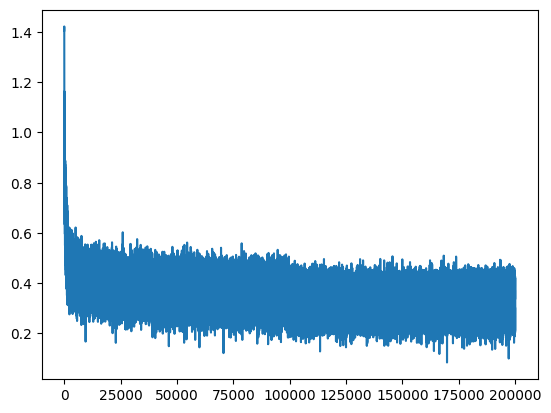

In [82]:
plt.plot(stepi, lossi)

In [83]:
emb = C[Xval]

# fwd pass 
h = torch.tanh((emb.view(Xval.shape[0],-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
loss = F.cross_entropy(logits,Yval)
loss

tensor(2.1837, grad_fn=<NllLossBackward0>)

In [84]:
emb = C[Xtst]

# fwd pass 
h = torch.tanh((emb.view(Xtst.shape[0],-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
loss = F.cross_entropy(logits,Ytst)
loss

tensor(2.1745, grad_fn=<NllLossBackward0>)

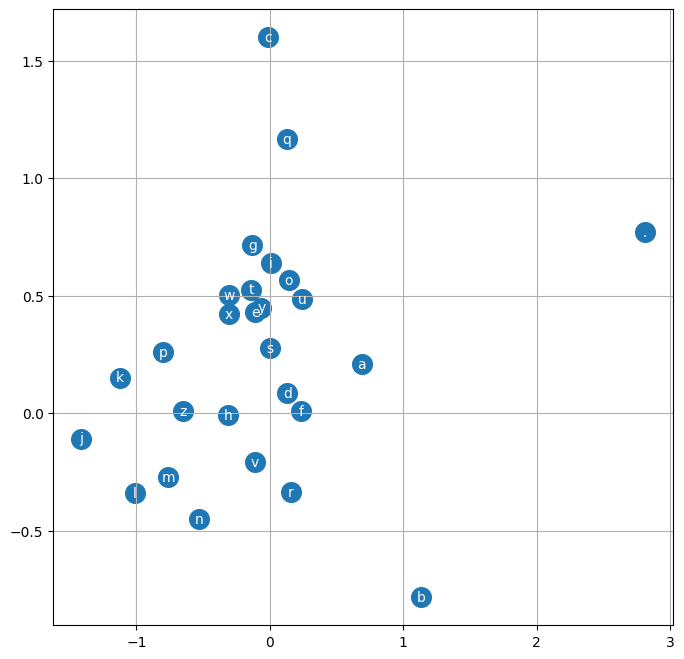

In [86]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [85]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ H + d)
        logits = h @ U + b
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amille.
khi.
mili.
taty.
salan.
kenrahnen.
deliah.
jareei.
ner.
kir.
chaiivin.
legy.
dham.
jorn.
quint.
sulin.
alian.
quinathon.
jaryn.
